In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [ ]:
df = pd.read_csv("Wholesale customers data.csv")

In [ ]:
print("dataset shape:",df.shape)
print("dataset columns:",df.columns.values)
print("\n",df.head(5))

dataset shape: (440, 8)
dataset columns: ['Channel' 'Region' 'Fresh' 'Milk' 'Grocery' 'Frozen' 'Detergents_Paper'
 'Delicassen']

    Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


In [ ]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [ ]:
data= df.copy()
data.drop(['Region', 'Channel'], axis = 1, inplace = True)
data.head(1)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338


# **Exploration using sample data**

In [ ]:
data_exp=data.sample(n = 3)
data_exp

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
415,7842,6046,8552,1691,3540,1874
386,1206,3620,2857,1945,353,967
116,11173,2521,3355,1517,310,222


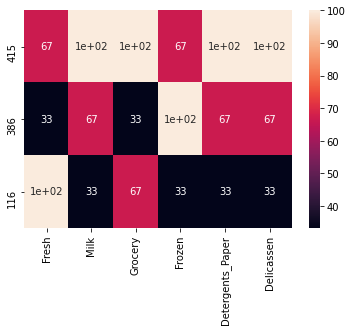

In [ ]:
percentile = 100 * data_exp.rank(pct = True).loc[list(data_exp.index)].round(decimals=5)
sns.heatmap(percentile,annot=True)

# ***Data Preprocessing***

In [ ]:
#check for missing values
df.isnull().value_counts()

Channel  Region  Fresh  Milk   Grocery  Frozen  Detergents_Paper  Delicassen
False    False   False  False  False    False   False             False         440
dtype: int64

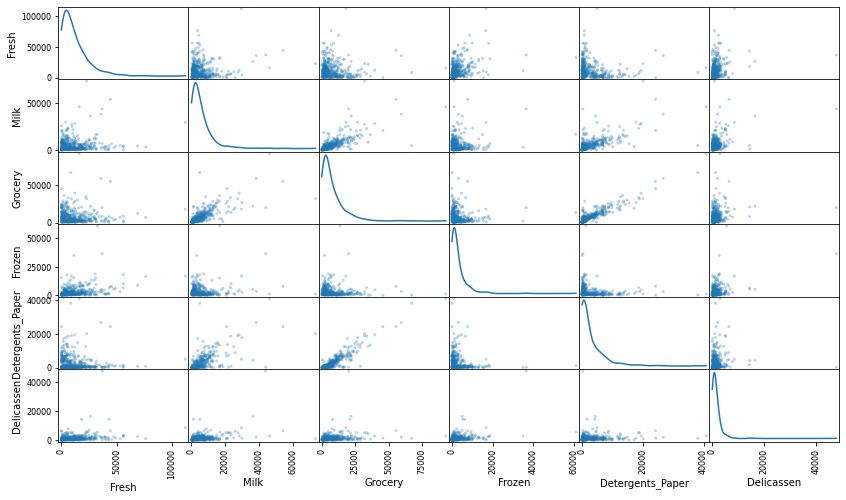

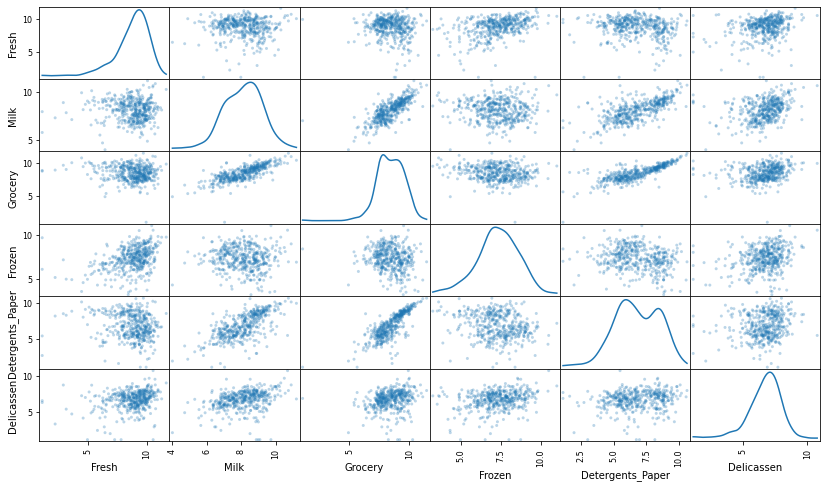

In [ ]:
#data transformation to reduce skewness
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
data_log = np.log(data)
pd.plotting.scatter_matrix(data_log, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [ ]:
#outlier detection and removal
q25, q75 = data_log.quantile(0.25), data_log.quantile(0.75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print("Identified outliers:",len(data_log[((data_log < (lower)) |(data_log > (upper))).any(axis=1)]))
data_log_out= data_log[~((data_log < (lower)) |(data_log > (upper))).any(axis=1)]
df_new=df[~((data_log < (lower)) |(data_log > (upper))).any(axis=1)]
print("old data shape:",data_log.shape)
print("new data shape:",data_log_out.shape)

new_data=data_log_out.copy()

Identified outliers: 42
old data shape: (440, 6)
new data shape: (398, 6)


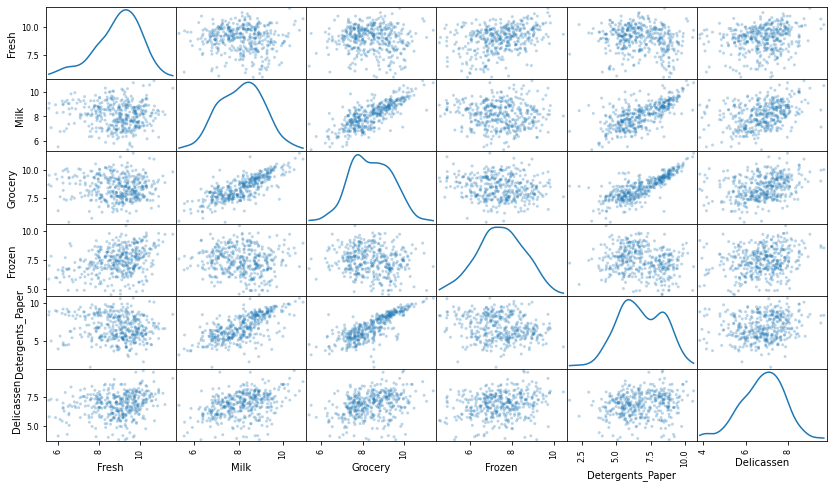

In [ ]:
#After outlier removal
pd.plotting.scatter_matrix(data_log_out, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

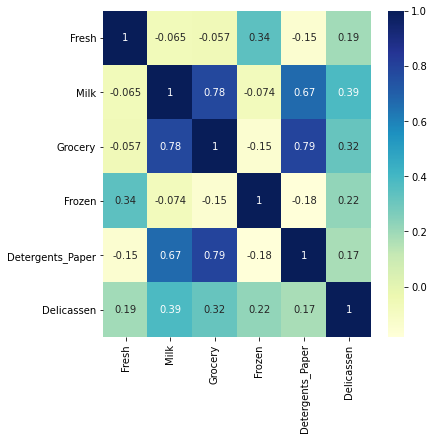

In [ ]:
#Finding correlation between the variables
corr=new_data.corr()
plt.figure(figsize=(6,6)) 
sns.heatmap(corr,cmap='YlGnBu',annot=True)

# **Product Relevance**

In [ ]:
#using supervised learning technique
for i in list(data.columns):
    new_data1 = data.drop([i], axis = 1)
    new_feature = pd.DataFrame(data.loc[:, i])
    X_train, X_test, y_train, y_test = train_test_split(new_data1, new_feature, test_size=0.25, random_state=42)
    clf= DecisionTreeRegressor()
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print('R square score for {} as dependent variable: {}'.format(i, score))
#r2 negative indicate dependent variables 

R square score for Fresh as dependent variable: -0.31896700490415375
R square score for Milk as dependent variable: 0.18889944381576318
R square score for Grocery as dependent variable: 0.7051598917649955
R square score for Frozen as dependent variable: -0.26179337937345015
R square score for Detergents_Paper as dependent variable: 0.5042627605366985
R square score for Delicassen as dependent variable: -11.491273693646527


# **Dimensionality reduction**

In [ ]:
def pca_results(good_data, pca):
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions
	fig, ax = plt.subplots(figsize = (14,8))
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))
	return pd.concat([variance_ratios, components], axis = 1)

def cluster_results(reduced_data, preds, centers):
	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, reduced_data], axis = 1)
	fig, ax = plt.subplots(figsize = (14,8))
	cmap = plt.cm.get_cmap('gist_rainbow')
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);


In [ ]:
new_data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


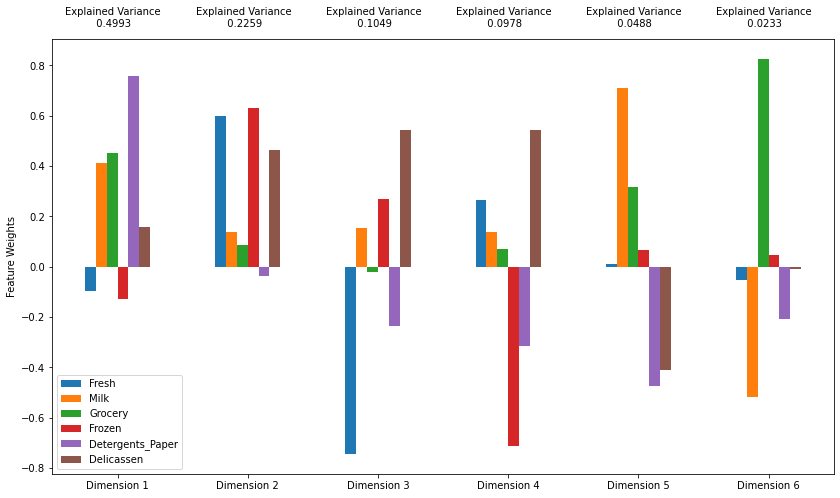

In [ ]:
pca = PCA(n_components=6)
pca.fit(new_data)
pca_samples = pca.transform(new_data)
pca_results = pca_results(new_data, pca)

In [ ]:
pca_results['Explained Variance']

Dimension 1    0.4993
Dimension 2    0.2259
Dimension 3    0.1049
Dimension 4    0.0978
Dimension 5    0.0488
Dimension 6    0.0233
Name: Explained Variance, dtype: float64

In [ ]:
pca = PCA(n_components=2)
pca.fit(new_data)
reduced_data = pca.transform(new_data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [ ]:
reduced_data

,Dimension 1,Dimension 2
0,1.779322,-0.660449
1,1.882034,0.461741
2,1.993507,1.247080
3,-0.998581,1.369364
4,0.993847,2.078314
...,...,...
393,1.092404,-0.088703
394,-0.363319,2.871768
395,-3.002061,1.868559
396,3.848267,0.144421


# **Post-hoc segmentation using clustering methods**

No guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data

The “goodness” of a clustering by calculating each data point’s silhouette coefficient.

**KMeans**

In [ ]:

score = {}
from sklearn.metrics import silhouette_score
for n in range(10, 2, -1):
    clusterer = KMeans(n_clusters=n, random_state=0).fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    centers = clusterer.cluster_centers_
    score_n = silhouette_score(reduced_data, preds, metric='euclidean')
    print ('Silhouette score for {} clusters: {}'.format(n, score_n))
    score[n] = silhouette_score(reduced_data, preds, metric='euclidean')

print ('Maximal Silhouette score is achieved when number of cluster N =',max(score, key=score.get))

Silhouette score for 10 clusters: 0.348267657109839
Silhouette score for 9 clusters: 0.3667615587335842
Silhouette score for 8 clusters: 0.3618630947516979
Silhouette score for 7 clusters: 0.35583739207228265
Silhouette score for 6 clusters: 0.3627610151267451
Silhouette score for 5 clusters: 0.3527972474280425
Silhouette score for 4 clusters: 0.3321215445650167
Silhouette score for 3 clusters: 0.3648740356118049
Maximal Silhouette score is achieved when number of cluster N = 9


In [ ]:
#Cluster the data for N clusters, where N is the numbers of clusters with Max silhouette coefficent value. 
clusterer = KMeans(n_clusters=max(score, key=score.get), random_state=0).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_

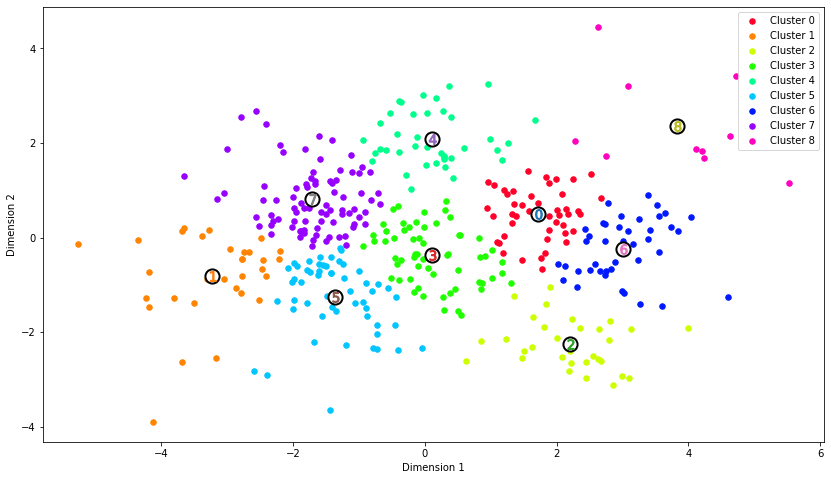

In [ ]:
#K means customer segment visualization
cluster_results(reduced_data, preds, centers)

**GMM**

In [ ]:
range_n_clusters = list(range(2,11))
score = {}
for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters).fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    centers = clusterer.means_
    score_n = silhouette_score(reduced_data, preds, metric='mahalanobis')
    print ('Silhouette score for {} clusters: {}'.format(n_clusters, score_n))
    score[n_clusters] = silhouette_score(reduced_data, preds, metric='mahalanobis')
print ('Maximal Silhouette score is achieved when number of cluster N =',max(score, key=score.get))

Silhouette score for 2 clusters: 0.37310483949112855
Silhouette score for 3 clusters: 0.34726723155654676
Silhouette score for 4 clusters: 0.32911494621155946
Silhouette score for 5 clusters: 0.2876077638032319
Silhouette score for 6 clusters: 0.28422366416350897
Silhouette score for 7 clusters: 0.18519613037078345
Silhouette score for 8 clusters: 0.32556233407183754
Silhouette score for 9 clusters: 0.26594168023507836
Silhouette score for 10 clusters: 0.301939820465229
Maximal Silhouette score is achieved when number of cluster N = 2


In [ ]:
#Cluster the data for N clusters, where N is the numbers of clusters with Max silhouette coefficent value. 
clusterer = GaussianMixture(n_components=max(score, key=score.get)).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_

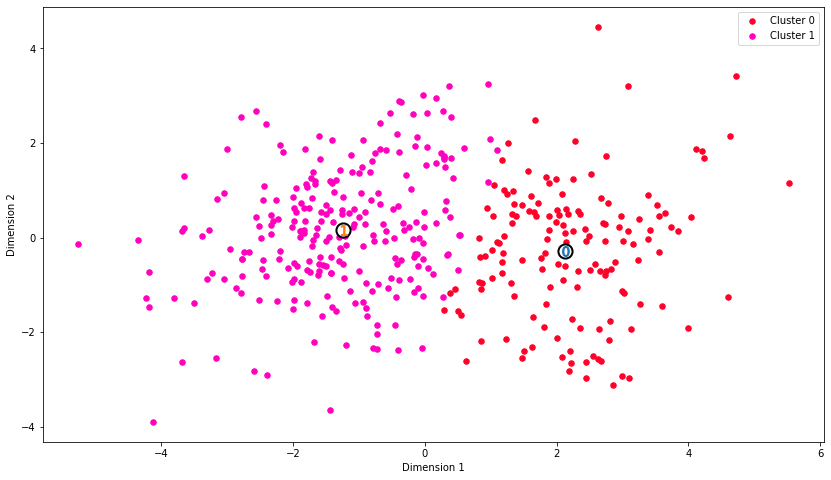

In [ ]:
#GMM customer segmentation visualization
cluster_results(reduced_data, preds, centers)

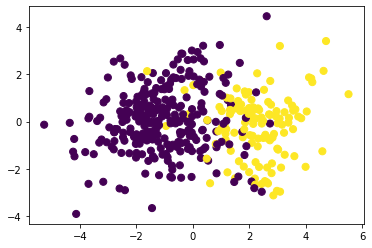

In [ ]:
#Data representation based on channel
plt.scatter(reduced_data['Dimension 1'], reduced_data['Dimension 2'], c=df_new['Channel'], s=50, cmap='viridis')

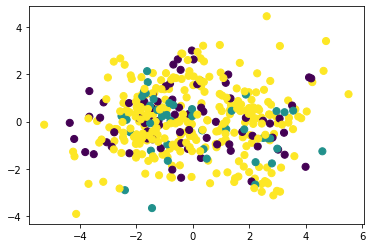

In [ ]:
#Data representation based on Region
plt.scatter(reduced_data['Dimension 1'], reduced_data['Dimension 2'], c=df_new['Region'], s=50, cmap='viridis')

# **Data Recovery**

*A cluster’s center point corresponds to the average customer spending of that segment*

*Recovers the customer spending from the reduced dataset*

In [ ]:
log_centers = pca.inverse_transform(centers)
true_centers = np.exp(log_centers)
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
print(true_centers)

            Fresh    Milk  Grocery  Frozen  Detergents_Paper  Delicassen
Segment 0  5174.0  7776.0  11581.0  1068.0            4536.0      1101.0
Segment 1  9468.0  2067.0   2624.0  2196.0             343.0       799.0


Segment 0: This segment best represents supermarkets.

Segment 1: This segment best represents restaurants. 

In [ ]:
data_exp

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
415,7842,6046,8552,1691,3540,1874
386,1206,3620,2857,1945,353,967
116,11173,2521,3355,1517,310,222
